# 載入需要套件

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from concurrent import futures
from tqdm import tqdm
import jieba
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

# 定義爬取每篇中時政治新聞內容函數

In [2]:
def article_crawler(link_list):
    link=link_list[0]
    i=link_list[1]
    r=requests.get(link)
    s=BeautifulSoup(r.text,'html.parser')
    
    articlecontent=s.select('p')
    article=[e.text for e in articlecontent]
    #去除無意義內容
    article=article[:-3]

    return i,article

# 定義爬取中時政治新聞資訊函數

In [3]:
def chinatimes_politics_crawler(url):
    response=requests.get(url)
    soup=BeautifulSoup(response.text,'html.parser')
    
    entrys=soup.select('ul>li')
    titles,links,hours,dates=[],[],[],[]
    for e in entrys:
        try:
            titles.append(e.select('h3>a')[0].text)
            links.append('https://www.chinatimes.com{}'.format(e.select('h3>a')[0]['href']))
            hours.append(e.select('span.hour')[0].text)
            dates.append(e.select('span.date')[0].text)
        except:
            None

    articles=[0]*len(links)

    link_list=[]
    for i in range(len(links)):
        link_list.append([links[i],i])
    
    
    #進入每個連結爬取(執行thread層級的非同步任務)
    with futures.ThreadPoolExecutor(max_workers=8) as executor:
        results=list(tqdm(executor.map(article_crawler,link_list),total=len(link_list)))
        for future in results:
            i,article=future
            articles[i]=''.join(article)
            
    df=pd.DataFrame({
        '標題':titles,
        '日期':dates,
        '時間':hours,
        '內容':articles,
        '網址':links
    })    
    
    return df

# 定義爬取中時新聞網政治新聞頁數函數

In [4]:
def page_function(page):
    dfs=[]
    
    for i in range(page):
        url='https://www.chinatimes.com/realtimenews/260407?page={}&chdtv'.format(i+1)
        d=chinatimes_politics_crawler(url)
        dfs.append(d)
    
    df=pd.concat(dfs,ignore_index=True)
    
    return df

# 指定總頁數表格呈現

In [5]:
df=page_function(8)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.15it/s]


In [6]:
df.head()

,標題,日期,時間,內容,網址
0,許虞哲過世 劉建忻抱屈：很多攻擊的人 自己什麼也沒做,2020/02/15,20:43,期貨交易所董事長許虞哲今天過世，當時也被歸為「老藍男」；總統府副秘書長劉建忻晚間在臉書表示，...,https://www.chinatimes.com/realtimenews/202002...
1,許虞哲過世 蔡總統：哀痛,2020/02/15,20:33,期貨交易所董事長許虞哲日前因病入院治療，今天下午過世，享壽67歲。總統府發言人張惇涵轉述，蔡...,https://www.chinatimes.com/realtimenews/202002...
2,罷韓二階段連署達30萬份 國民黨嗆6字,2020/02/15,20:30,罷韓第二階段連署已突破30萬份關卡，3月中旬將向高雄市選委會遞件。國民黨高雄市黨部主委莊啟旺...,https://www.chinatimes.com/realtimenews/202002...
3,郝龍斌：我無派系、不把黨主席當跳板 能擺脫國民黨舊包袱,2020/02/15,20:07,國民黨主席候選人郝龍斌今天在臉書貼文表示，很多人不看好國民黨的改革，因為國民黨黨內老舊宮廷文...,https://www.chinatimes.com/realtimenews/202002...
4,為傅崐萁恢復黨籍鋪路 國民黨18日中央考紀會討論,2020/02/15,19:31,國民黨中常會日前通過無黨籍立委傅崐萁恢復黨籍案，因程序不完備引爭議，今天傅所屬的黃復興黨部花...,https://www.chinatimes.com/realtimenews/202002...


# 將新聞標題分詞

In [17]:
titles=df['標題'].values.tolist()
#'\u3000',' ','[^\w\s]','／','《','》','，','。','「','」','（','）','！','？','、','▲','…','：','...','-','︰','；','.'
text=''.join(titles).replace('\u3000','').replace(' ','').replace('[^\w\s]','').replace('／',"").replace('《','').replace('》','').replace('，','').replace('。','').replace('「','').replace('」','').replace('（','').replace('）','').replace('！','').replace('？','').replace('、','').replace('▲','').replace('…','').replace('：','').replace('...','').replace('-','').replace('︰','').replace('；','').replace('.','')

jieba.load_userdict('political.txt')
sentence=jieba.cut(text,cut_all=False)
print('精確模式: '+'/ '.join(sentence))

精確模式: 校友/ 會/ 推特賀/ 蔡當選/ 彭文正/ 卻/ 爆/ LSE/ 證實/ 一件/ 事罷/ 免案/ 王世堅/ 給韓/ 建議/ 宅/ 神超/ 贊同/ 加碼/ 送/ 12/ 字/ BBC/ 專訪/ 全文/ 總統/ 使/ 臺/ 灣成/ 為/ 亞洲/ 最/ 進步/ 國家/ 顏寬恒/ 沈智慧/ 李永萍/ 票/ 增加/ 卻/ 仍輸/ 名嘴/ 驚爆/ 原因/ 砍/ 國民黨/ 百年老/ 妖/ 周錫瑋/ 緩步/ 趨近/ ｣/ 黨主席/ 內閣/ 改組/ 向/ 對岸/ 示好/ 蘇揆/ 不用/ 其他/ 國家/ 指指/ 點點府院/ 人事/ 將異動/ 知情/ 官員/ 目前/ 穩定/ 為/ 前提/ 特勤/ 吳彥祖/ 遭打/ 回原/ 外圍/ 單位/ 傳/ 因公/ 開/ 私人/ IG/ 違反/ 規定/ 韓國瑜/ 選後首/ 開/ 直播/ 呼籲/ 暫時/ 不談/ 政治/ 民眾黨/ 立家規/ 立委/ 連/ 2/ 會期/ 評鑑/ 差/ 即/ 開除/ 黨籍/ 特勤/ 吳彥祖/ 太高調/ 傳維安高層/ 抱怨/ 都/ 在後頭/ 幫/ 他/ 善/ 後/ 台中/ 立委/ 當選人/ 贈/ 名家/ 揮/ 毫春聯助/ 弱勢/ 在野/ 大聯盟/ 有/ 譜/ 國民黨/ 願/ 與/ 民眾黨/ 同/ 推/ 民生/ 經濟/ 陳/ 柏惟要/ 電他/ 林佳龍/ 反/ 嗆/ 好/ 膽麥/ 走罷/ 韓要/ 花/ 8/ 千萬高/ 市府/ 只能/ 舉債/ 陳菊/ 否/ 認將/ 卸任/ 強調/ 不會/ 擔任/ 罷韓/ 操盤/ 手竹/ 東鎮長/ 補選/ 2/ 參選人/ 成立/ 競選/ 總部/ 誰/ 是/ 下任/ 黨主席/ 國民黨/ 青壯派/ 只服/ 他/ 副/ 總統/ 讓/ 每個/ 孩子/ 都/ 得到/ 好/ 的/ 照顧/ 台灣/ 要入/ 聯獨派/ 建議/ 蔡/ 這樣/ 做/ 柯志恩/ 想/ 甩/ 美白/ 小腿/ 主人/ 巴掌/ 網紅律/ 師震/ 驚/ 4/ 問/ 外交部/ 雙出擊/ 赴/ 中美洲/ 及/ 太平洋/ 穩固邦誼/ 宛如/ 巨星/ 吳怡農/ 謝票/ 現場/ 綿延/ 300/ 公尺/ 傳/ 佈/ 局/ 台北市/ 羅文嘉/ 妻沒有/ 要/ 跟/ 你/ 們/ 搶/ 位置/ 小英/ 將成史/ 上/ 聲望/ 最高/ 總統網/ 不/ 可能/ 大/ 政治/ 大/ 爆掛/ 無色/ 覺醒/ 高雄人/ 好忙/ 一路/ 拚選舉/ 到/ 2022/ 

# 繪製文字雲

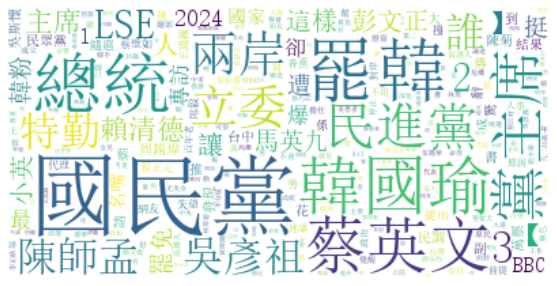

In [18]:
#設定停用字
stopwords={}.fromkeys(['也','但','來','個','再','的','和','是','有','更','會','可能','有何',
                       '從','對','就','越','為','這種','多','越','要','在','把','於','以','間',
                       '應','與','了','你','我','他','沒','不要','事','被','嗎','說','都','不',
                       '嗆'])
sentence=jieba.cut(text,cut_all=False)

#統計字詞頻率
hash={}
for item in sentence:
    if item in stopwords:
        continue    
    if item in hash:
        hash[item]+=1
    else:
        hash[item]=1

#畫圖
wc=WordCloud(font_path='simsun.ttc',
             background_color='white',
             max_words=2000,
             stopwords=stopwords)
wc.generate_from_frequencies(hash)

plt.figure(figsize=(10,5))
#雙線性插值法
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

# 統計詞頻結果

In [19]:
artdf=pd.DataFrame.from_dict(hash,orient='index',columns=['詞頻'])
artdf.sort_values(by=['詞頻'],ascending=False).head(10)

,詞頻
國民黨,18
罷韓,11
總統,10
蔡英文,9
韓國瑜,9
黨主席,8
民進黨,8
立委,7
兩岸,7
3,6
